# **"Гиперболические ИПСоиды"'s solution to [iMaterialist (Fashion) 2019 at FGVC6](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6) completed as a selection task to INT20TH Hackathon**

### Setting up global variables and libraries

In [ ]:
import os
import sys
import glob
import json
import random
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

In [ ]:
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
DATA_PATH = os.path.abspath("data")
ROOT_PATH = os.path.abspath("")

We are choosing a 512x512 image size and ignoring class attributes, since they are difficult to predict and without them, the metrics are better. Besides, according to the host, 80% of images have no attributes at all. So we'll predict only classes

In [ ]:
IMG_SIZE = 512
CLASS_NUM = 46

## Choosing model and downloading it's weights

We've looked through all the State of the Art solutions for Instance Segmentation and for this task we've chosen *Mask R-CNN* because:
* it's still considered as one of the STA solutions, despite the fact that it was published almost 2 years ago
* it's relatively light-weighted in comparison to other models
* we were able to train it on a custom data using kaggle kernels in quite a restricted time frame (other models, like *Hybrid Task Cascade with ResNeXt-101-64x4d-FPN*, would have taken an enormous time to train on kaggle

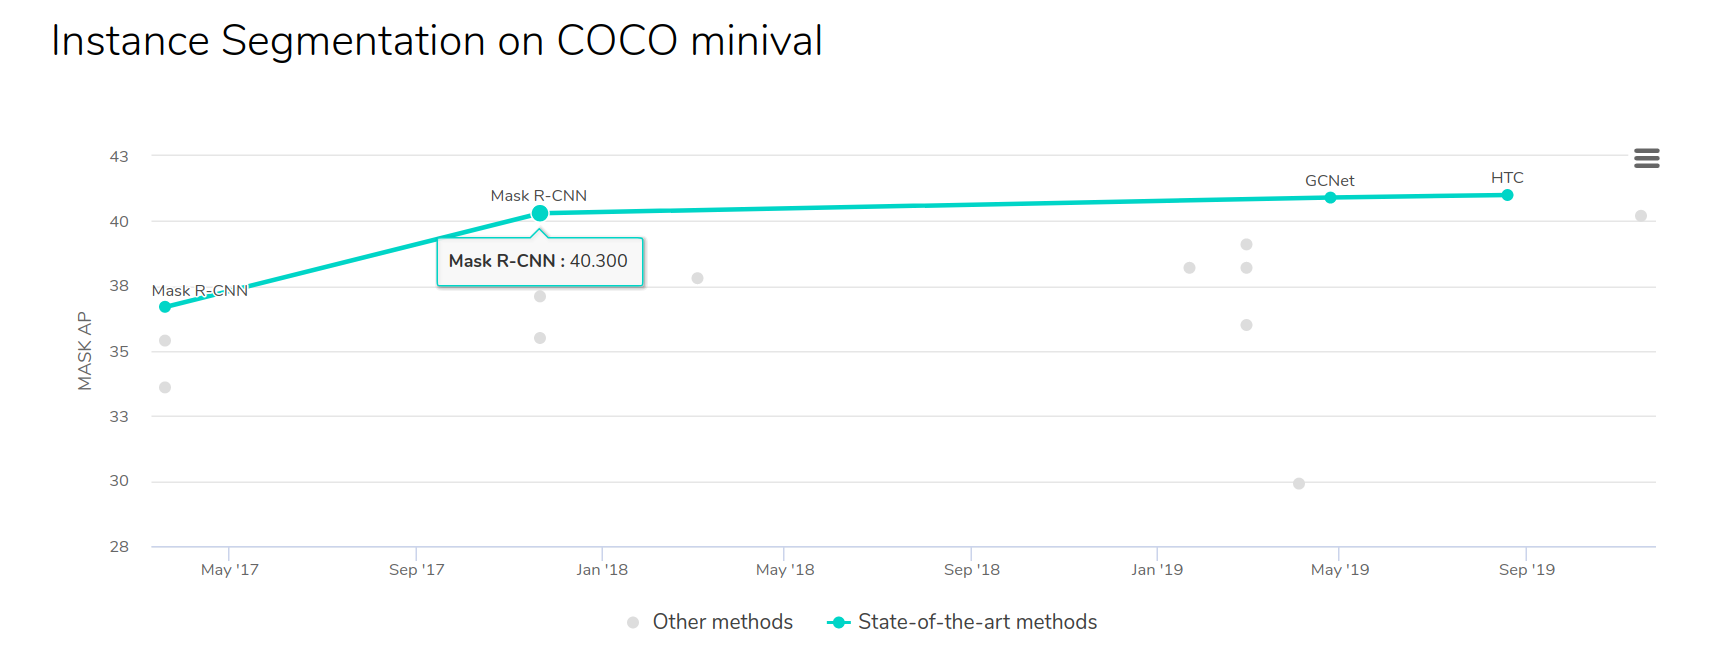

In [ ]:
#clonning the model and it's pretrained on COCO dataset weights
#!git clone https://www.github.com/matterport/Mask_RCNN.git
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [ ]:
sys.path.append(str(ROOT_PATH + '/Mask_RCNN'))
initial_weights_path = ROOT_PATH + "/weights/mask_rcnn_coco.h5"

In [ ]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn.config import Config

## Creating configuration files

In [ ]:
class TrainingConfig(Config):
    """Configuration used to train the model on Kaggle kernels"""
    NAME = "fashion"
    NUM_CLASSES = CLASS_NUM + 1
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMG_SIZE
    IMAGE_MAX_DIM = IMG_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = TrainingConfig()
config.display()

In [ ]:
class TestingConfig(TrainingConfig):
    """Configuration used to test the model locally, using the pretrained weights"""
    IMAGES_PER_GPU = 1

testing_config = TestingConfig()

## Creating Datasets for the model

In [ ]:
with open(DATA_PATH + "/label_descriptions.json") as file:
    label_descriptions = json.load(file)

label_names = [x['name'] for x in label_descriptions['categories']]

In [ ]:
segment_df = pd.read_csv(DATA_PATH + "/train.csv")

In [ ]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]  # 10(classId)_1_2_3(attributeIds) => 10
segment_df.sample(10)

As we see, one image may have multiple attributes. So we grup them up

In [ ]:
segment_df = segment_df.set_index("ImageId")
train_idxs, test_idxs = train_test_split(np.unique(segment_df.index.values), test_size=0.2, random_state=42, shuffle=True)

train_df_raw = segment_df.loc[train_idxs]
test_df_raw = segment_df.loc[test_idxs]

In [ ]:
train_image_df = train_df_raw.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
train_size_df = train_df_raw.groupby('ImageId')['Height', 'Width'].mean()
train_image_df = train_image_df.join(train_size_df, on='ImageId')

print("Total train images: ", len(train_image_df))
train_image_df.head()

In [ ]:
test_image_df = test_df_raw.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
test_size_df = test_df_raw.groupby('ImageId')['Height', 'Width'].mean()
test_image_df = test_image_df.join(test_size_df, on='ImageId')

print("Total test images: ", len(test_image_df))
test_image_df.head()

In [ ]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)  
    return img

Redefining *utils.Dataset* for our use case

In [ ]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_PATH + '/train/'+ row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMG_SIZE, IMG_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

Image and their masks examples 

In [ ]:
dataset = FashionDataset(train_image_df)
dataset.prepare()

test_dataset = FashionDataset(test_image_df)
test_dataset.prepare()

for i in range(3):
    image_id = random.choice(dataset.image_ids)    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

Partitioning data into train and validation sets. Since we can't validate our prediction using Kaggle, we'll calculate final validation score using 20% of the train data

In [ ]:
# since we want to test our model on the data it never saw, we'll split it
train_df, valid_df = train_test_split(train_image_df, test_size=0.2, random_state=42, shuffle=True)

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

Let's check the class distribution of the splitted datasets

In [ ]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total validation images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

# Training

Taking into account similarities between COCO and iMaterialist datasets, we've decided to use Transfer Learning and to use pre-trained weights of the Mask R-CNN model. We've trained only the top part of our model for 10 epochs. Because each epoch took more than 1 hour to finish, we did that is a few kernel sessions, gradually decreasing learning rate as we came closer to loss minimum. We used the following learning rate scheduler:
```
lr = 1e-2
if epochs > 6: 
    lr = lr ∗ 0.1 
if epochs > 8: 
    lr = lr ∗ 0.1 
if epochs == 10: 
    lr = lr ∗ 0.1```

In [ ]:
weights_path = ROOT_PATH + "/weights/mask_rcnn_fashion_0010.h5"

To make our model more robust and diversify our dataset we've used image augmentations:

In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flip
    iaa.Multiply((0.3, 1.2), per_channel=0.5), # change brightness of images (30-120% of original value)
    iaa.ContrastNormalization((0.3, 1.2), per_channel=0.5),
    iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.arithmetic.JpegCompression((80, 90))
])

In [ ]:
# model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_PATH)

# #loading weights from previous epoch
# model.load_weights(weights_path, by_name=True)

In [ ]:
# model.train(train_dataset, valid_dataset,
#         learning_rate=lr,
#         epochs=epochs,
#         layers='heads',
#         augmentation=augmentation)

```Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrcnn_class_logits     (TimeDistributed)
mrcnn_mask             (TimeDistributed)
Epoch 8/10
1000/1000 [==============================] - 2440s 2s/step - loss: 2.8838 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 1.0405 - mrcnn_class_loss: 0.5922 - mrcnn_bbox_loss: 0.5446 - mrcnn_mask_loss: 0.5982 - val_loss: 2.6346 - val_rpn_class_loss: 0.0930 - val_rpn_bbox_loss: 1.1380 - val_mrcnn_class_loss: 0.5197 - val_mrcnn_bbox_loss: 0.4304 - val_mrcnn_mask_loss: 0.4535
Epoch 9/10
1000/1000 [==============================] - 2095s 2s/step - loss: 2.4895 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 0.9998 - mrcnn_class_loss: 0.4837 - mrcnn_bbox_loss: 0.4418 - mrcnn_mask_loss: 0.4615 - val_loss: 2.1939 - val_rpn_class_loss: 0.0790 - val_rpn_bbox_loss: 0.8786 - val_mrcnn_class_loss: 0.4575 - val_mrcnn_bbox_loss: 0.3915 - val_mrcnn_mask_loss: 0.3873
Epoch 10/10
1000/1000 [==============================] - 2224s 2s/step - loss: 2.4348 - rpn_class_loss: 0.1020 - rpn_bbox_loss: 1.0466 - mrcnn_class_loss: 0.4370 - mrcnn_bbox_loss: 0.4171 - mrcnn_mask_loss: 0.4320 - val_loss: 2.0614 - val_rpn_class_loss: 0.0791 - val_rpn_bbox_loss: 0.8100 - val_mrcnn_class_loss: 0.4405 - val_mrcnn_bbox_loss: 0.3720 - val_mrcnn_mask_loss: 0.3599
CPU times: user 26min 42s, sys: 2min 20s, total: 29min 3s
Wall time: 1h 55min 13s```

## Testing

In [ ]:
model_path = ROOT_PATH + "/weights/mask_rcnn_fashion_0007.h5"

model = modellib.MaskRCNN(mode='inference', 
                          config=testing_config,
                          model_dir=ROOT_PATH)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

#### Some helper functions to get EncodedPixels from masks

In [ ]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle


# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [ ]:
# number of images to predict from the test set
num_to_predict = 1000

# or to select all (~9k)
# num_to_predict= len(test_idxs)

In [ ]:
# predictions themselves

%%time
sub_list = []
missing_count = 0
for i, row in enumerate(test_image_df.index.values[:num_to_predict]):
    
    image = resize_image(DATA_PATH + '/train/'+ row)
    
    result = model.detect([image])[0]
    
    if result['masks'].size > 0:
        
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row, ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row, '1 1', 23])
        missing_count += 1

In [ ]:
prediction_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
print("Total image results: ", submission_df['ImageId'].nunique())
print("Missing Images: ", missing_count)
prediction_df.head()

In [ ]:
prediction_df.to_csv("predictions_1000_007.csv", index=False)

In [ ]:
prediction_df = pd.read_csv("predictions_1000_007.csv", index_col="ImageId").drop(columns=["Unnamed: 0"])

In [ ]:
prediction_df = prediction_df.rename({"ClassId":"CategoryId"}, axis=1)
prediction_df.head()

In [ ]:
print("Masks detected:", len(prediction_df)) 
print("Images predicted:", len(np.unique(prediction_df.index.values)))

Let's visualise results!

In [ ]:
for i in range(4):
    image_id = prediction_df.sample().index.values[0]
    image_path = str(DATA_PATH + '/train/'+ image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMG_SIZE
        x_scale = img.shape[1]/IMG_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        print(image_id)
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))

## Evaluating the model

In [ ]:
# calculating ground_truth encoded pixels relativly to 512x512 size
gt_list = []

for idx in tqdm(range(num_to_predict)):
    image, image_meta, gt_class_id, gt_roi, gt_mask = modellib.load_image_gt(test_dataset, 
                                                                              TestingConfig, 
                                                                              idx)
    masks, _ = refine_masks(gt_mask, gt_roi)
    for m in range(masks.shape[-1]):

        mask = masks[:, :, m].ravel(order='F')
        rle = to_rle(mask)
        label = gt_class_id[m] - 1
        gt_list.append([test_idxs[idx], ' '.join(list(map(str, rle))), label])

In [ ]:
gt_df = pd.DataFrame(gt_list)
gt_df = gt_df.rename({0:"ImageId", 1:"EncodedPixels", 2:"CategoryId"}, axis=1).set_index("ImageId")

#### Helper functions to compute comtetion's metric

In [ ]:
def calc_IoU(A,B):
    AorB = np.logical_or(A,B).astype('int')
    AandB = np.logical_and(A,B).astype('int')
    IoU = AandB.sum() / AorB.sum()
    return IoU

def rle_to_mask(rle_list, SHAPE):
    tmp_flat = np.zeros(SHAPE[0]*SHAPE[1])
    if len(rle_list) == 1:
        mask = np.reshape(tmp_flat, SHAPE).T
    else:
        strt = rle_list[::2]
        length = rle_list[1::2]
        for i,v in zip(strt,length):
            tmp_flat[(int(i)-1):(int(i)-1)+int(v)] = 255
        mask = np.reshape(tmp_flat, SHAPE).T
    return mask

def calc_IoU_threshold(data):
    # Note: This rle_to_mask should be called before loop below for speed-up! We currently implement here to reduse memory usage.
    mask_gt = rle_to_mask(data['EncodedPixels_gt'].split(), (int(data['Height']), int(data['Width'])))
    mask_pred = rle_to_mask(data['EncodedPixels_pred'].split(), (int(data['Height']), int(data['Width'])))
    return calc_IoU(mask_gt, mask_pred)

def evaluation(gt_df, pred_df):
    eval_df = pd.merge(gt_df, pred_df, how='outer', on=['ImageId', 'CategoryId'], suffixes=['_gt', '_pred'])
    #return eval_df
    # IoU for True Positive
    idx_ = eval_df['EncodedPixels_gt'].notnull() & eval_df['EncodedPixels_pred'].notnull()
    
    IoU = eval_df[idx_].apply(calc_IoU_threshold, axis=1)

    # False Positive
    fp = (eval_df['EncodedPixels_gt'].isnull() & eval_df['EncodedPixels_pred'].notnull()).sum()

    # False Negative
    fn = (eval_df['EncodedPixels_gt'].notnull() & eval_df['EncodedPixels_pred'].isnull()).sum()

    threshold_IoU = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    scores = []
    for th in threshold_IoU:
        # True Positive
        tp = (IoU > th).sum()
        maybe_fp = (IoU <= th).sum()

        # False Positive (not Ground Truth) + False Positive (under IoU threshold)
        fp_IoU = fp + maybe_fp

        # Calculate evaluation score
        score = tp / (tp + fp_IoU + fn)
        scores.append(score)
        print(f"Threshold: {th}, Precision: {score}, TP: {tp}, FP: {fp_IoU}, FN: {fn}")

    mean_score = sum(scores) / len(threshold_IoU)
    print(f"Mean precision score: {mean_score}")

In [ ]:
# check that there is equal amount of images in gt_df and predicted_df
assert len(np.unique(prediction_df.index.values)) == len(np.unique(gt_df.index.values))

In [ ]:
gt_df["CategoryId"] = gt_df["CategoryId"].astype("int64")

gt_df["Height"] = 512
gt_df["Width"] = 512

prediction_df = prediction_df.reset_index()
gt_df = gt_df.reset_index()

In [ ]:
prediction_df.sample(10)

In [ ]:
gt_df.sample(10)

In [ ]:
%%time
evaluation(gt_df, prediction_df)